<a href="https://colab.research.google.com/github/Teagan0207/sycamore/blob/master/demoCreditGAN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#demoCreditGAN.py
# This program aims to use DC-GAN to overcome imbalance in credit risk scoring


In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [0]:
# read data to cloud
from google.colab import files
uploaded=files.upload() 

Saving credit_risk_clean_data.csv to credit_risk_clean_data.csv


In [0]:
# now read it officially as dataFrame
import io
filename='credit_risk_clean_data.csv'
# the onlt difference is io.BytesIO(uploaded(...))
credit_data=pd.read_csv(io.BytesIO(uploaded[filename]))
print(credit_data.shape)
print(credit_data.head())

(120269, 11)
   Delinquency  Revolving Credit Percentage  ...  Num Late 90  Num Employees
0            1                     0.766127  ...            0            2.0
1            0                     0.957151  ...            0            1.0
2            0                     0.658180  ...            0            0.0
3            0                     0.233810  ...            0            0.0
4            0                     0.907239  ...            0            0.0

[5 rows x 11 columns]


In [0]:
# start a copy
df=credit_data
df.head()


,Delinquency,Revolving Credit Percentage,Capital Reserves,Num Late 60,Debt Ratio,Monthly Income,Num Credit Lines,Num Late Past 90,Num Real Estate,Num Late 90,Num Employees
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [0]:

test=df.drop('Delinquency',axis=1)  # drop the 'Deliquency' column
test=test.reset_index(drop=True)
## reshape data to 3D
test=test.values.reshape(test.shape[0], test.shape[1],1)
print(test.shape)


(120269, 10, 1)


In [0]:
# do normalization
normalization_bit=0
if normalization_bit:
  from sklearn.preprocessing import StandardScaler
  scaler=StandardScaler()
  scaler.fit(credit_data.iloc[:,1:credit_data.shape[1]])
  normalized_data=scaler.transform(credit_data.iloc[:,1:credit_data.shape[1]])
  credit_data_.iloc[:,1:credit_data.shape[1]]=normalized_data
# X_test.loc[:]=sc.transform(X_test.loc[:])

In [0]:
y=credit_data['Delinquency']
print(credit_data.head())
## minority data
real=credit_data[credit_data['Delinquency']==1]
real=real.drop('Delinquency', axis=1)
print(real.shape)


## Majority type data
fake=credit_data[credit_data['Delinquency']==0]
fake=fake.drop('Delinquency', axis=1)
#fake.shape
#type(fake)

   Delinquency  Revolving Credit Percentage  ...  Num Late 90  Num Employees
0            1                     0.766127  ...            0            2.0
1            0                     0.957151  ...            0            1.0
2            0                     0.658180  ...            0            0.0
3            0                     0.233810  ...            0            0.0
4            0                     0.907239  ...            0            0.0

[5 rows x 11 columns]
(8357, 10)


In [0]:
## reshaape data for CNN
real_=real.values.reshape(real.shape[0], real.shape[1],1) # minority type
fake_=fake.values.reshape(fake.shape[0], fake.shape[1],1)  # majority type
#print(type(real_))

In [0]:
import os
import tensorflow as tf
from keras.utils import plot_model
import pydot
import graphviz
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from numpy import expand_dims, zeros, ones, vstack
from numpy.random import randn, randint
from keras.optimizers import Adam, SGD
from keras.models import Sequential  
from keras.layers import Dense, Reshape, Flatten,Conv1D, Conv2D,UpSampling1D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization  
from matplotlib import pyplot
from keras.preprocessing import image
from cv2 import cv2
from PIL import Image
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [0]:
## define disctiminator by CNN
## No pooling procedure for CNN

## 1D-CNN

def define_discriminator(in_shape=(10,1)):
  
  ## input shape is the shape of each sample with n=10 elements

    model = Sequential()
    
    # input layer with size 10x1 (a sample vecor)
    # stride default :1
    # kernel size=2
    # filter=64 (# neuron)
    
    # convoultion layer 1
    model.add(Conv1D(64, 2, padding='same', input_shape=in_shape))
    # 𝑓1(𝑥)=max(0,𝑥)−𝛼max(0,−𝑥)
    # leaky ReLU has an alpha term
    model.add(LeakyReLU(alpha=0.2))

     # convoultion layer 2
    model.add(Conv1D(128, 2, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    ## DO batch normalaization
    model.add(BatchNormalization())

    # convoultion layer 3
    model.add(Conv1D(64, 2, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

   # convoultion layer 4
    model.add(Conv1D(32, 2, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(BatchNormalization())
   
   # falttern layer 
    model.add(Flatten())
  
  # dense layer
    model.add(Dense(64))
    model.add(Activation('tanh'))
    model.add(Dropout(0.1))

  ## output layer (dense layer 2)
    model.add(Dense(1, activation='sigmoid'))
   
  # compile discrinator
  # The learning rate will decide the loss change somewhat
    # use AMAM optimizer 
    opt = Adam(lr=0.0001, beta_1=0.9)  # learning rate is super important!!

  ## discrimator's 1D-CNN 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
   
    return model

In [0]:
## define a generator by 1D-CNN
## Generate will generate minority and majority samples

def define_generator(latent_dim):
    model = Sequential()

    n_nodes = 256 * 2
  

  ## dense layer 1

    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.30))
    model.add(Reshape((2,256)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # upsampling twice for input

    model.add(UpSampling1D(size=2))
    ## convolution layer 1
    model.add(Conv1D(128,3,activation='relu', padding='same'))
    #model.add(LeakyReLU(alpha=0.2))

    ## upsampling 2 times for 1D input 
    model.add(UpSampling1D(size=2))
  
    ## convolution layer 2
    model.add(Conv1D(60,3,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.20))
    model.add(Reshape((10,-1)))
    # convolution layer 3: output layer

    model.add(Conv1D(1, 3, activation='tanh', padding='same'))

    opt = Adam(lr=0.0001, beta_1=0.7, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

In [0]:
## define a GAN according to two 1D-CNNs
## add g_model and d_model then do optimization using ADAM

def define_gan(g_model, d_model):
    
    d_model.trainable = False
    model = Sequential()

    model.add(g_model)
    model.add(d_model)
  # make a standard ADAM learning
    opt = Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:

## generate 'real' samples ('Deliquency') with class label
## here we use real_--> the ndrray of the original DataFrame real
from numpy.random import randn, randint

## randomly select 'real' samples: 
## aka minority type samples

def generate_real_samples( n_samples):
    global real_
    ix = randint(0, len(real_), n_samples)
    y = ones((n_samples, 1))   

    X = []  
    for f in range (len(ix)):
        X.append(real_[ix[f]])

    return np.array(X), np.array(y)

In [0]:

## generate latent points: majority type samples
## randomly selected majority samples
## the samples have no label

def generate_latent_points( n_samples):
    global fake_  # majority samples 

    ix = randint(0, len(fake_), n_samples)

    X=[]
    for f in range (len(ix)):
        X.append(fake_[ix[f]]+ randn())
    
    X=np.array(X).reshape(n_samples,10)
    return X

In [0]:
## generate fake samples: then learn this one
## aka: majority samples 

def generate_fake_samples(g_model, n_samples):
    x_input = generate_latent_points(n_samples)  # randomly select maajority samples
  
  # generator preicts a bunch of outputs for x_input
    #print("this is x_input\n")
    #print(x_input)
    X = g_model.predict(x_input) ## generator learning
    #print(" this is predicted X based on X-input\n")
    
    y = zeros((n_samples, 1))  ## majority type label
    #print([X,y])
    return X, y

In [0]:
# checking generate fake samples
#X1, Y1=generate_fake_samples(g_model, 2)

In [0]:
def summarize_performance(epoch, g_model, d_model, n_samples=100):
    print("################# Summarize ###################")
    ## detect real (minority samples)
    X_real, y_real = generate_real_samples( n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  
  ## detect fake (majority) samples
    x_fake, y_fake = generate_fake_samples(g_model,  n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print('>Accuracy: minority (real) class: %6.2f%%, majority (fake) class: %6.2f%%'
     % (acc_real*100, acc_fake*100))


In [0]:
def summarize_performance_2(epoch, g_model, d_model, n_samples=1000):
    print("################# Summarize ###################")
    ## detect real (minority samples)
    X_real, y_real = generate_real_samples(n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  
  ## detect fake (majority) samples
    x_fake, y_fake = generate_fake_samples(g_model,  n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print('>Accuracy: minority (real) class: %6.2f%%, majority (fake) class: %6.2f%%'
     % (acc_real*100, acc_fake*100))
    return acc_real, acc_fake

In [0]:
#############################################################################
#train GAN

#Possible case is g_loss increases along with d_loss_1 and d_loss_2 decrease
#The generator finds it almost impossible to fool the discriminator
#Henece the generator increases its loss--> starts to diverge?

# It means it can only produce valueless noise 
## It is possible D encouters overfitting

#############################################################################


from keras.layers import Input
from keras.layers.core import Lambda,Activation

## TRAIN discriminator and generator under minibatch
import time
def train_2(g_model, d_model, gan_model,  latent_dim, n_epochs=50, n_batch=3000):
    global real_
    
    bat_per_epo = int(len(real_) / n_batch)
    print('Batchs per epoch: {:d}'.format(bat_per_epo))

    half_batch = int(n_batch / 2)

##  checking loss for discriminator aand generator
    d_loss_1_=[]
    d_loss_2_=[]
    g_loss_  =[]
    real_accuracy=[]
    fake_accuracy=[]
    for i in range(n_epochs):
        
        for j in range(bat_per_epo):
          
            # generate  randomly selected 'minority class samples
            X_real, y_real = generate_real_samples(half_batch)     
            ## let discrimnator assess     
            ## d_loss1: discrimator's loss for assessing minority data
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)

            # generate majority class samples 
            X_fake, y_fake = generate_fake_samples(g_model,  half_batch)

            ## let discriminator assess
            # d_loss2: discrominator's losss for assessing majority data
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            
            # generate latent points (majority class) with label
            X_gan = generate_latent_points( n_batch)
            y_gan = ones((n_batch, 1))
            
            ## train GAN
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            ## minitor progress
            #if i%5==0:
            #  print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            #   (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
           
            d_loss_1_.append(d_loss1)
            d_loss_2_.append(d_loss2)
            g_loss_.append(g_loss)

    ## summarize performane
        if (i+1) % 2 == 0:
          t1, t2=summarize_performance_2(i, g_model, d_model)
          real_accuracy.append(t1)
          fake_accuracy.append(t2)
    


    return d_model, g_model, d_loss_1_, d_loss_2_, g_loss_, real_accuracy, fake_accuracy




In [0]:
###############################################
## train GAN
###############################################
# size of the latent space
latent_dim = 10

# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# training GAN
## call GPU support
with tf.device('/device:GPU:0'):
  d_model, g_model, d_loss_1_, d_loss_2_, g_loss_, real_accuracy, fake_accuracy=train_2(g_model, d_model, gan_model,  latent_dim)


Batchs per epoch: 2
################# Summarize ###################
>Accuracy: minority (real) class:  99.90%, majority (fake) class:   0.00%
################# Summarize ###################
>Accuracy: minority (real) class:  99.90%, majority (fake) class:   0.00%
################# Summarize ###################
>Accuracy: minority (real) class:  99.80%, majority (fake) class:   0.00%
################# Summarize ###################
>Accuracy: minority (real) class:  99.80%, majority (fake) class:   0.00%
################# Summarize ###################
>Accuracy: minority (real) class:  99.90%, majority (fake) class:   0.00%
################# Summarize ###################
>Accuracy: minority (real) class: 100.00%, majority (fake) class:   0.00%
################# Summarize ###################
>Accuracy: minority (real) class: 100.00%, majority (fake) class:   0.00%
################# Summarize ###################
>Accuracy: minority (real) class: 100.00%, majority (fake) class:   0.00%
####

In [0]:
# save the existing results to a pickle file

import pickle
filename='GAN_dataNEW.pickle'
fp=open(filename, 'wb')
gan_data=[d_loss_1_, d_loss_2_, g_loss_]
pickle.dump(gan_data, fp)
print(" " + filename + "is saved!\n")

 GAN_dataNEW.pickleis saved!



GAN_loss2.png is saved



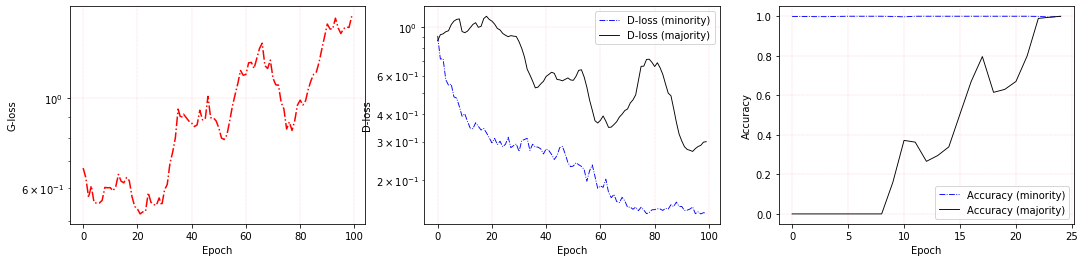

In [0]:
import matplotlib.pyplot as plt

with tf.device('/device:GPU:0'):
  fig=plt.figure(figsize=(18,4))

  plt.subplot(1,3,1)
  plt.plot(g_loss_, 'r-.')
  plt.ylabel('G-loss')
  plt.xlabel('Epoch') 
  plt.yscale('log')
  plt.grid('True', lw=0.3, color='r',linestyle=':', alpha=0.6)

  plt.subplot(1,3,2)
  plt.plot(d_loss_1_, 'b-.', lw=0.9)
  plt.ylabel('D-loss')
  plt.plot(d_loss_2_, 'k', lw=0.9)
  plt.legend(['D-loss (minority)','D-loss (majority)'], loc='left')
  plt.xlabel('Epoch') 
  plt.yscale('log')
  plt.grid('True', lw=0.3, color='r', linestyle=':', alpha=0.6)

  plt.subplot(1,3,3)
  plt.plot(real_accuracy, 'b-.', lw=0.9)
  plt.plot(fake_accuracy, 'k-', lw=0.9)
  plt.legend(['Accuracy (minority)','Accuracy (majority)'])
  plt.xlabel('Epoch') 
  plt.ylabel('Accuracy')
 
  plt.grid('True', lw=0.3, color='r', linestyle=':', alpha=0.6)
  filename='GAN_loss2.png'
  fig.savefig(filename, dpi=601)
  print(filename + " is saved\n")
## The D has a al,ost z loss but G's loss increases

In [0]:
from keras.layers import Input
from keras.layers.core import Lambda,Activation
test=df.drop('Delinquency',axis=1)
test=test.reset_index()
test=test.values.reshape((test.shape[0],  test.shape[1],1))
re_test=d_model.predict(test)

ValueError: ignored

In [0]:
d_model.evaluate(test, df['Delinquency'])
re_test=d_model.predict(test)
pd.Series(re_test.flatten()).value_counts()